## Housing Price Vizualization & Predictions 

In [389]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Linear Regression model 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [390]:
# Read in data:
df = pd.read_csv('../data/ames.csv')

In [391]:
# Display for ease of viewing features and plots.
pd.set_option('display.max_columns',None)
sns.set_style('darkgrid')

In [392]:
df.shape

(2051, 81)

In [393]:
df.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


### EDA:

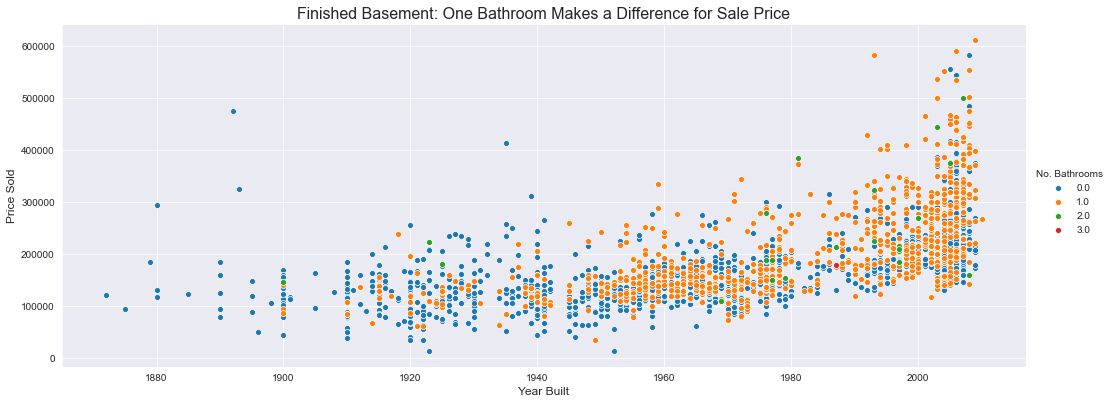

In [394]:
# Visualize relationships with Year Built feature and others.
# It can be assumed the features from the dataset are not independent
# Ralatiionship of Price to Year Built by Bathroom count in basement

sns.pairplot(df,y_vars='SalePrice',x_vars='Year Built',
           hue='Bsmt Full Bath',
             height=5.2,aspect=2.7)._legend.set_title('No. Bathrooms')

plt.title('Finished Basement: One Bathroom Makes a Difference for Sale Price',size=16)
plt.ylabel('Price Sold',size=12)
plt.xlabel('Year Built',size=12);

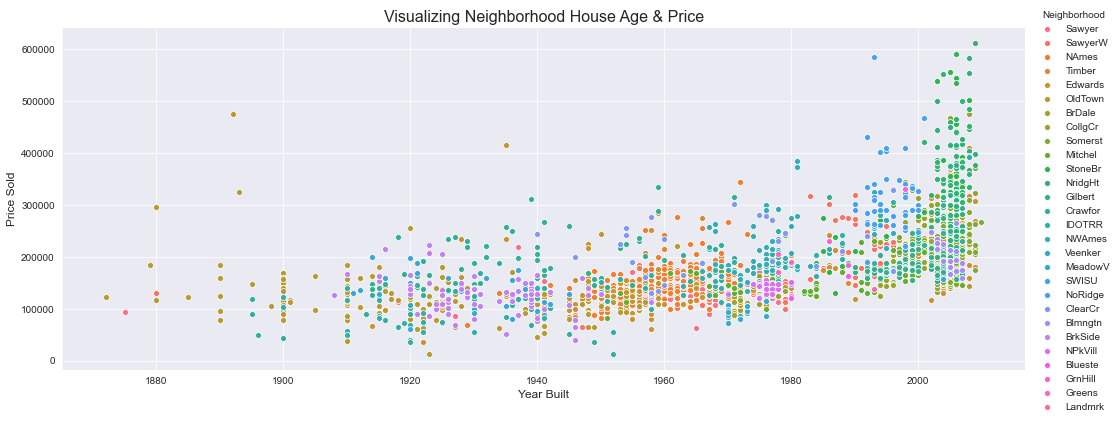

In [395]:
# Same relationship by Neighborhood
# Basic clustering can be seen.

sns.pairplot(df,y_vars='SalePrice',x_vars='Year Built',
           hue='Neighborhood',
             height=5.2,aspect=2.7)._legend.set_title('Neighborhood')

plt.title('Visualizing Neighborhood House Age & Price',size=16)
plt.ylabel('Price Sold',size=12)
plt.xlabel('Year Built',size=12);

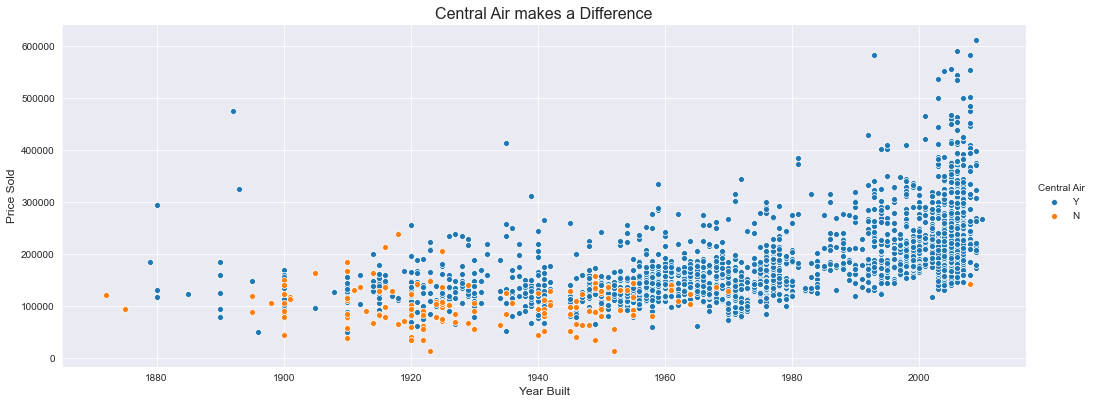

In [396]:
# Same relationship by Central Air

sns.pairplot(df,y_vars='SalePrice',x_vars='Year Built',
           hue='Central Air',
             height=5.2,aspect=2.7)._legend.set_title('Central Air')

plt.title('Central Air makes a Difference',size=16)
plt.ylabel('Price Sold',size=12)
plt.xlabel('Year Built',size=12);

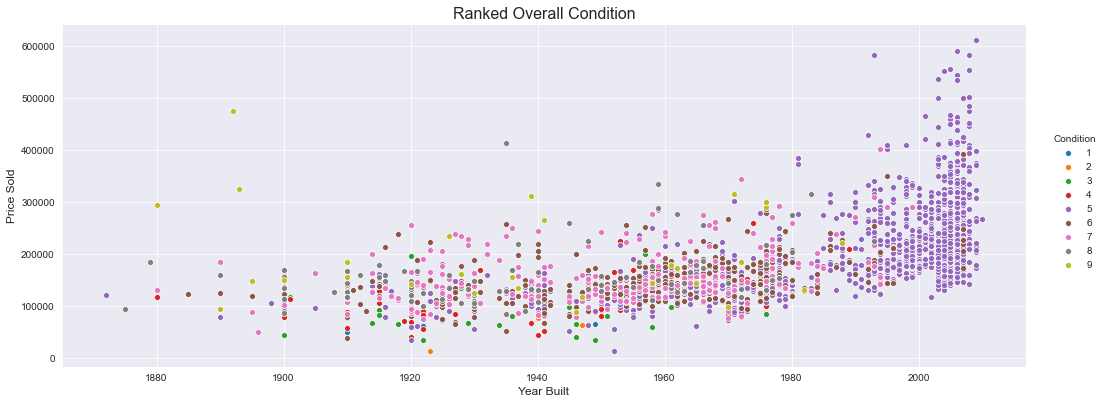

In [397]:
# Same relationship by Overall Condition
# Even more expensive and newer homes rank with the average overall condition.

sns.pairplot(df,y_vars='SalePrice',x_vars='Year Built',
           hue='Overall Cond',
             height=5.2,aspect=2.7)._legend.set_title('Condition')

plt.title('Ranked Overall Condition',size=16)
plt.ylabel('Price Sold',size=12)
plt.xlabel('Year Built',size=12);

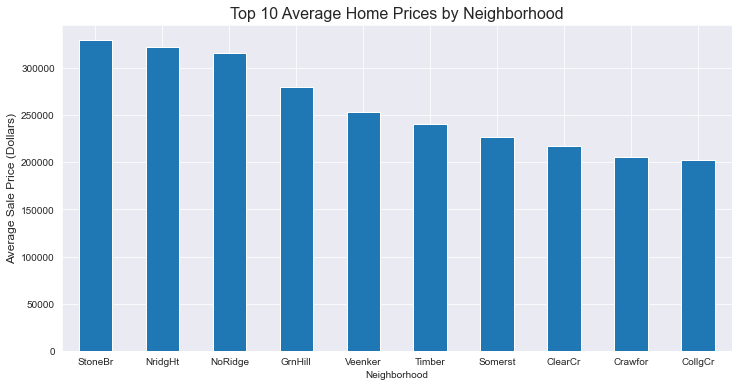

In [398]:
# Visualizing average prices in Ames Neighborhoods

plt.figure(figsize=(12,6))
df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Average Home Prices by Neighborhood',size=16)
plt.ylabel('Average Sale Price (Dollars)',size=12)
plt.xticks(rotation=0);

### Cleaning, Dummies and Numeric Ordinal Ranking of Features:

In [399]:
# List of nominal features for encoding. Features selected with guidance from original Data Dictionary.

nom_features = ['MS Zoning','Street','Alley','Lot Config','Land Contour','Neighborhood',
               'Condition 1','Condition 2','Bldg Type','House Style','Roof Style',
               'Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation',
               'Heating','Central Air','Garage Type','Sale Type','Misc Feature']

ord_features = ['Lot Shape','Utilities','Land Slope','Exter Qual','Exter Cond',
               'Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
               'Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu',
               'Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC',
               'Fence','Overall Qual','Overall Cond']

In [400]:
# Encode nominal categorical features.
df = pd.get_dummies(data=df,columns=nom_features,drop_first=True)

In [401]:
# verify encoding
df.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_Pave,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC
0,109,533352170,60,NaN,13517,IR1,AllPub,Gtl,6,8,1976,2005,289.0,Gd,TA,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,Ex,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,0,3,2010,130500,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,544,531379050,60,43.0,11492,IR1,AllPub,Gtl,7,5,1996,1997,132.0,Gd,TA,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,Ex,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,0,4,2009,220000,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [402]:
# Separate DataFrame for standardizing categories of ordinal features.
ordinals = df[ord_features].fillna('NA')

In [403]:
# Create maps for orindal categories for relevant features
# Guidance for creating these maps came from the native Data Dictionary from the original publisher.

order_lotshape = {'Reg':'Ex','IR1':'Gd','IR2':'TA','IR3':'Fa','NA':'NA'}
order_util = {'AllPub':'Ex','NoSewr':'Gd','NoSeWa':'TA','ELO':'Fa','NA':'NA'}
order_landslope = {'Gtl':'Ex','Mod':'Gd','Sev':'TA','NA':'NA'}
order_bsFin = {'GLQ':'Ex','ALQ':'Gd','BLQ':'TA','Rec':'Fa','LwQ':'Po','Unf':'Po','NA':'NA'}
order_elec = {'SBrkr':'Ex','FuseA':'Gd','FuseF':'TA','FuseP':'Fa','Mix':'Po','NA':'NA'}
order_func = {'Typ':'Ex','Min1':'Gd','Min2':'TA','Mod':'Fa','Maj1':'Po','Maj2':'Po','Sev':'Po','Sal':'Po','NA':'NA'}
order_garage_fin = {'Fin':'Ex','RFn':'Gd','Unf':'TA','NA':'NA'}
order_paved = {'Y':'Ex','P':'Gd','N':'TA','NA':'NA'}
order_fence = {'GdPrv':'Ex','MnPrv':'Gd','GdWo':'TA','MnWw':'Fa','NA':'NA'}
order_map_Qual = {10:'Ex',9:'Ex',8:'Gd',7:'Gd',6:'Gd',5:'TA',4:'TA',3:'Fa',2:'Po',1:'Po','NA':'NA'}

In [404]:
# Map standard categories on each ordinal feature 

ordinals['Lot Shape'] = ordinals['Lot Shape'].map(order_lotshape)
ordinals['Utilities'] = ordinals['Utilities'].map(order_util)
ordinals['Land Slope'] = ordinals['Land Slope'].map(order_landslope)
ordinals['BsmtFin Type 1'] = ordinals['BsmtFin Type 1'].map(order_bsFin)
ordinals['BsmtFin Type 2'] = ordinals['BsmtFin Type 2'].map(order_bsFin)
ordinals['Electrical'] = ordinals['Electrical'].map(order_elec)
ordinals['Functional'] = ordinals['Functional'].map(order_func)
ordinals['Garage Finish'] = ordinals['Garage Finish'].map(order_garage_fin)
ordinals['Paved Drive'] = ordinals['Paved Drive'].map(order_paved)
ordinals['Fence'] = ordinals['Fence'].map(order_fence)
ordinals['Overall Qual'] = ordinals['Overall Qual'].map(order_map_Qual)
ordinals['Overall Cond'] = ordinals['Overall Cond'].map(order_map_Qual)

In [405]:
# Verify mapped categories
ordinals['Paved Drive'].value_counts()

Ex    1861
TA     151
Gd      39
Name: Paved Drive, dtype: int64

In [406]:
# auto setting assigns 0 to 'Best' ordinal category with 5 being the 'worst'
# This numerical ordered encoding will be reversed with another map function.

encoder = OrdinalEncoder()
ordinals_encoded = encoder.fit_transform(ordinals)

In [407]:
# Encoding of Ordinal features.
ordinal_df = pd.DataFrame(ordinals_encoded,columns=ord_features)

In [408]:
# Verification of encoding.
ordinal_df['Overall Cond'].value_counts()

4.0    1238
2.0     739
1.0      35
0.0      29
3.0      10
Name: Overall Cond, dtype: int64

In [409]:
ordinals['Overall Cond'].value_counts()

TA    1238
Gd     739
Fa      35
Ex      29
Po      10
Name: Overall Cond, dtype: int64

In [410]:
ordinals['Fence'].value_counts()

NA    1651
Gd     227
Ex      83
TA      80
Fa      10
Name: Fence, dtype: int64

In [411]:
ordinal_df['Fence'].value_counts()

3.0    1651
2.0     227
0.0      83
4.0      80
1.0      10
Name: Fence, dtype: int64

In [412]:
# Reverse Numerical categories where now 5 will equal 'Best'
reverse_cats = {0:5,2:4,4:3,1:2,3:1}

for col in ordinal_df.columns:
    ordinal_df[col] = ordinal_df[col].map(reverse_cats)

In [413]:
# Drop unencoded ordinal features from original DataFrame.
df = df.drop(columns=ord_features).copy()

In [414]:
# Add back encoded orindal features
df = pd.concat([df,ordinal_df],axis=1)

In [415]:
df.isnull().sum()

Id                0
PID               0
MS SubClass       0
Lot Frontage    330
Lot Area          0
               ... 
Paved Drive       0
Pool QC           0
Fence             0
Overall Qual      0
Overall Cond      0
Length: 196, dtype: int64

In [416]:
# remove remaining null values
df = df.fillna(0).copy()

### Modeling & Metric Evaluations:

In [417]:
X.shape

(2051, 193)

In [418]:
# Create features and target matrix.
X = df.drop(columns=['Id','PID','SalePrice'])
y = df['SalePrice']

In [419]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=77)

In [420]:
# scale data in advance of PCA
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [421]:
# Initialize Regression Model
lr = LinearRegression()

In [422]:
# fit model
lr.fit(Xs_train,y_train)

LinearRegression()

In [423]:
# Evaluate train and test scores
# No PCA shows very poor model results at this stage.

print('Train r2: ',lr.score(Xs_train,y_train))
print('Test r2: ',lr.score(Xs_test,y_test))

Train r2:  0.9246006670838369
Test r2:  -4.639523703452557e+20


In [424]:
# CVS for precision in model score comparisons.

print('CVS train: ',cross_val_score(lr,Xs_train,y_train).mean())
print('CVS test: ',cross_val_score(lr,Xs_test,y_test).mean())

CVS train:  -5.7932927391910855e+20
CVS test:  -1.9068660098054935e+24


### Linear Model Metrics:

In [425]:
# Predictions
preds = lr.predict(Xs_test)

In [426]:
# MSE from TTS data
# Extremely high MSE initially
mean_squared_error(y_test, preds)

2.969555622053722e+30

In [427]:
# RMSE
np.sqrt((mean_squared_error(y_test, preds)))

1723239862019713.8

In [428]:
# Null Prediction
y.mean()

181469.70160897123

In [429]:
# Display coefficient values for each feature.
pd.DataFrame(set(zip(X.columns, lr.coef_))).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,Roof Matl_WdShake,Open Porch SF,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Roof Matl_CompShg,Exterior 2nd_Stone,Sale Type_Oth,Wood Deck SF,Neighborhood_Sawyer,Garage Qual,Neighborhood_Greens,Condition 1_PosA,Full Bath,Neighborhood_MeadowV,Sale Type_ConLD,Bldg Type_Twnhs,Roof Matl_WdShngl,Neighborhood_NoRidge,Enclosed Porch,Garage Type_Detchd,Overall Cond,Lot Config_FR2,Year Built,Foundation_Stone,Condition 2_PosN,Roof Style_Shed,Exter Cond,Roof Matl_Membran,Lot Area,Misc Feature_Othr,Sale Type_ConLw,Exter Qual,Bldg Type_TwnhsE,House Style_2.5Fin,MS Zoning_RH,Functional,MS SubClass,Exterior 2nd_MetalSd,Garage Area,Mas Vnr Type_None,Heating QC,Bedroom AbvGr,Garage Finish,Sale Type_CWD,Neighborhood_NPkVill,Bsmt Half Bath,Exterior 1st_Stone,Neighborhood_Crawfor,Condition 2_RRAn,Garage Yr Blt,Alley_Pave,Garage Cond,Condition 1_RRNn,Bsmt Exposure,Foundation_CBlock,Mas Vnr Type_BrkFace,Condition 1_RRNe,Condition 1_Norm,Exterior 2nd_VinylSd,Fireplace Qu,Neighborhood_NridgHt,Bsmt Full Bath,Neighborhood_SWISU,Bsmt Qual,1st Flr SF,Land Slope,Foundation_PConc,Exterior 1st_BrkComm,Fireplaces,Gr Liv Area,Electrical,Fence,Neighborhood_Timber,Neighborhood_Edwards,Bsmt Cond,MS Zoning_I (all),House Style_2Story,Garage Type_Basment,TotRms AbvGrd,BsmtFin Type 1,Neighborhood_Somerst,Exterior 1st_CBlock,Half Bath,House Style_2.5Unf,Condition 2_PosA,Neighborhood_Blueste,Neighborhood_BrDale,Condition 1_Feedr,2nd Flr SF,Neighborhood_NWAmes,Neighborhood_Landmrk,Lot Frontage,Roof Style_Hip,Screen Porch,Exterior 2nd_BrkFace,Exterior 2nd_HdBoard,Central Air_Y,Neighborhood_Gilbert,Neighborhood_StoneBr,Exterior 1st_HdBoard,Foundation_Wood,Neighborhood_NAmes,Bsmt Unf SF,Utilities,Bldg Type_2fmCon,House Style_1Story,Garage Cars,Condition 1_PosN,MS Zoning_RL,Land Contour_Lvl,Garage Type_CarPort,Exterior 1st_Wd Sdng,Exterior 1st_VinylSd,Condition 1_RRAn,BsmtFin SF 2,Exterior 2nd_Wd Sdng,Neighborhood_SawyerW,Low Qual Fin SF,Roof Matl_Tar&Grv,Kitchen AbvGr,Paved Drive,Neighborhood_IDOTRR,Condition 2_RRAe,Mas Vnr Area,Exterior 1st_BrkFace,Exterior 1st_ImStucc,Exterior 1st_Stucco,Heating_GasW,Sale Type_Con,Misc Feature_Shed,Neighborhood_ClearCr,Heating_Grav,Roof Style_Gambrel,Exterior 2nd_ImStucc,Pool QC,BsmtFin Type 2,Condition 2_RRNn,House Style_1.5Unf,Exterior 2nd_Brk Cmn,Heating_OthW,Year Remod/Add,Condition 2_Feedr,Neighborhood_GrnHill,House Style_SLvl,Exterior 1st_WdShing,Neighborhood_Mitchel,Exterior 1st_AsphShn,Lot Config_CulDSac,Exterior 2nd_Wd Shng,Roof Style_Gable,Exterior 2nd_Plywood,Garage Type_BuiltIn,Mas Vnr Type_Stone,Land Contour_Low,Neighborhood_BrkSide,MS Zoning_FV,Kitchen Qual,Neighborhood_Veenker,Exterior 2nd_AsphShn,Garage Type_Attchd,Foundation_Slab,Total Bsmt SF,Misc Val,MS Zoning_RM,Exterior 1st_Plywood,Mo Sold,Sale Type_ConLI,Neighborhood_OldTown,Lot Shape,Condition 1_RRAe,Exterior 1st_CemntBd,Yr Sold,House Style_SFoyer,Exterior 1st_MetalSd,3Ssn Porch,Heating_Wall,BsmtFin SF 1,Pool Area,Bldg Type_Duplex,Lot Config_Inside,Land Contour_HLS,Exterior 2nd_Stucco,Neighborhood_CollgCr,Misc Feature_Gar2,Condition 2_Norm,Lot Config_FR3,Street_Pave,Sale Type_New,Overall Qual,Roof Style_Mansard,MS Zoning_C (all),Misc Feature_TenC,Sale Type_WD
1,1.40618e+15,995.125,258.75,-5959.31,2.96931e+15,916.789,1555.12,943.969,-2455.84,1890.75,384.062,1051.88,-1764.19,-1399.98,1405.69,-5384.88,1.21818e+15,1164.8

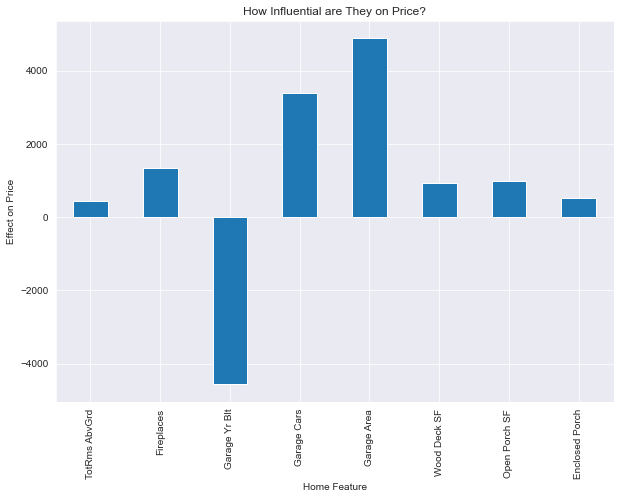

In [430]:
# Credit to Riley Dallas for this instruction:
# Visualize strnegth of particular model coefficients:

pd.Series(lr.coef_[20:28],index=X.columns[20:28]).plot.bar(figsize=(10, 7))

plt.title('How Influential are They on Price?')
plt.ylabel('Effect on Price')
plt.xlabel('Home Feature');

### Regression Assumption Tests:

In [431]:
# Calculate model residuals.
resids = y_test - preds

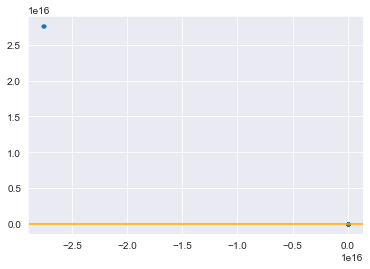

In [432]:
# Display distribution of model residuals.
plt.scatter(preds,resids,s=10)
plt.axhline(0,color='orange');

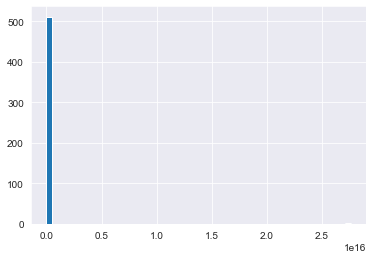

In [433]:
# Validate residual distribution with histogram.
# All results are poor at this stage as we have not transformed any features.
plt.hist(resids,bins=50);

In [434]:
# View of correlated features in X matrix.
X.corr()

,MS SubClass,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_Pave,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Lot Shape,Utilities,Land Slope,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Overall Qual,Overall Cond
MS SubClass,1.000000,-0.216259,-0.245484,0.035983,0.044836,-0.002763,-0.060425,-0.068129,-0.139292,-0.224700,-0.246212,0.305771,0.031091,0.068210,0.025727,-0.017030,0.142087,0.179404,-0.003516,0.252111,0.034490,-0.055118,-0.110858,-0.049426,-0.108423,0.001622,-0.020289,-0.039842,-0.030088,-0.038819,-0.004585,-0.027485,0.013027,-0.032870,-0.002754,0.168529,-0.013933,0.101227,-0.321879,0.249682,0.025201,0.192416,-0.061390,0.067542,0.013253,0.063847,0.001957,-0.050187,0.011990,0.113432,0.232612,-0.033922,-0.009915,-0.111953,0.016033,-0.007255,0.005274,0.056311,0.045966,0.013352,0.053130,0.263873,-0.008122,-0.175427,0.179726,-0.069770,-0.008770,0.010830,0.027476,0.044174,-0.081689,-0.000834,0.106979,0.094050,-0.081084,0.008899,-0.047922,0.053430,-0.042423,-0.046384,-0.048325,0.018878,-0.030104,-0.004650,0.016045,-0.0

### Regularization Tests - Lasso & Ridge:

In [435]:
# Instantiate Ridge
# Alpha regularization strength set initially at 8000.
# aggressively regularizing here gives modent scores with overfitting that is not too significant.

ridge_model = Ridge(alpha=8000)
ridge_model.fit(Xs_train,y_train)

# side by side comparsion of train and test scores after regularization
ridge_model.score(Xs_train,y_train), ridge_model.score(Xs_test,y_test)

(0.7690464677342385, 0.7225784700013813)

In [436]:
# Ridge output coefficients for comparison.
pd.DataFrame(set(zip(X.columns, ridge_model.coef_))).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,Exterior 1st_AsphShn,Garage Area,Condition 1_RRAn,Utilities,Condition 2_RRAe,Neighborhood_OldTown,Roof Style_Hip,Misc Feature_Othr,Exterior 1st_MetalSd,Total Bsmt SF,Low Qual Fin SF,BsmtFin Type 2,1st Flr SF,MS Zoning_RH,Misc Feature_Shed,Neighborhood_MeadowV,Roof Matl_WdShake,Mas Vnr Type_None,Foundation_PConc,Neighborhood_SWISU,Exterior 1st_Stone,Heating_Wall,Garage Type_Attchd,Sale Type_ConLD,Screen Porch,MS Zoning_FV,Neighborhood_Veenker,Garage Finish,Roof Style_Shed,Neighborhood_SawyerW,Bsmt Qual,Exterior 2nd_BrkFace,Heating_Grav,Neighborhood_NWAmes,Neighborhood_Crawfor,Bsmt Half Bath,Sale Type_ConLI,Exterior 2nd_MetalSd,Neighborhood_NPkVill,Year Remod/Add,Roof Style_Gambrel,Exterior 2nd_HdBoard,Kitchen AbvGr,Roof Style_Gable,Garage Cond,Neighborhood_BrDale,Mas Vnr Type_Stone,Condition 1_RRNe,Neighborhood_NridgHt,Half Bath,Exterior 1st_CBlock,Exterior 2nd_Wd Sdng,Heating_OthW,Functional,Neighborhood_StoneBr,Mo Sold,MS Zoning_RL,Neighborhood_CollgCr,Electrical,Sale Type_Oth,Neighborhood_Edwards,BsmtFin SF 2,Misc Val,Bldg Type_2fmCon,Sale Type_CWD,Bsmt Exposure,Neighborhood_NAmes,Bsmt Cond,Open Porch SF,Bsmt Full Bath,House Style_1Story,Bldg Type_Duplex,Land Slope,Exterior 2nd_AsphShn,Garage Cars,Condition 1_Feedr,Land Contour_Lvl,Fence,Bedroom AbvGr,Condition 2_RRAn,Bldg Type_Twnhs,Exterior 1st_CemntBd,Garage Qual,Exterior 1st_VinylSd,Land Contour_HLS,Land Contour_Low,Roof Matl_WdShngl,Garage Type_Basment,Heating_GasW,Gr Liv Area,Exterior 2nd_CBlock,Neighborhood_Timber,Foundation_CBlock,Kitchen Qual,House Style_2.5Fin,Neighborhood_Sawyer,Exterior 1st_HdBoard,Overall Qual,Condition 2_PosN,Condition 2_Feedr,Neighborhood_BrkSide,Garage Type_Detchd,Full Bath,Garage Yr Blt,Exterior 2nd_Wd Shng,Foundation_Slab,BsmtFin SF 1,Neighborhood_Landmrk,Pool Area,Exterior 2nd_VinylSd,Exterior 2nd_ImStucc,Exterior 2nd_Stone,Neighborhood_Mitchel,Yr Sold,Lot Area,Lot Frontage,Neighborhood_GrnHill,Lot Config_FR2,Lot Config_Inside,Exterior 2nd_Plywood,Mas Vnr Type_BrkFace,Bsmt Unf SF,Roof Style_Mansard,Foundation_Stone,Sale Type_WD,Exterior 1st_BrkComm,Condition 1_PosA,Exterior 2nd_Stucco,Mas Vnr Area,MS SubClass,Overall Cond,Roof Matl_Membran,Bldg Type_TwnhsE,House Style_2.5Unf,Exterior 1st_WdShing,Exterior 2nd_CmentBd,House Style_SFoyer,House Style_1.5Unf,Neighborhood_Somerst,Enclosed Porch,Neighborhood_IDOTRR,Alley_Pave,Fireplace Qu,Year Built,Lot Config_CulDSac,House Style_SLvl,MS Zoning_C (all),Misc Feature_TenC,Exterior 1st_Stucco,Exter Qual,Neighborhood_NoRidge,Foundation_Wood,Heating QC,BsmtFin Type 1,Central Air_Y,2nd Flr SF,Paved Drive,Street_Pave,Condition 1_RRAe,Exterior 1st_Wd Sdng,MS Zoning_RM,Neighborhood_Gilbert,Roof Matl_CompShg,Roof Matl_Tar&Grv,Wood Deck SF,Neighborhood_Blueste,Condition 1_RRNn,MS Zoning_I (all),Exterior 1st_BrkFace,Neighborhood_ClearCr,Sale Type_Con,Condition 2_Norm,Exterior 2nd_Brk Cmn,Sale Type_New,Exter Cond,3Ssn Porch,Neighborhood_Greens,Misc Feature_Gar2,Condition 1_Norm,House Style_2Story,Fireplaces,TotRms AbvGrd,Lot Config_FR3,Condition 2_PosA,Garage Type_CarPort,Sale Type_ConLw,Pool QC,Lot Shape,Condition 1_PosN,Exterior 1st_ImStucc,Garage Type_BuiltIn,Exterior 1st_Plywood,Condition 2_RRNn
1,0,3137.26,-188.416,136.271,0,-695.61,1430.69,-139.801,-427.767,3280.4,69.3617,489.979,3376.6,-53.687,-163.551,-712.787,164.171,-1588.69,1775.34,-251.592,184.9

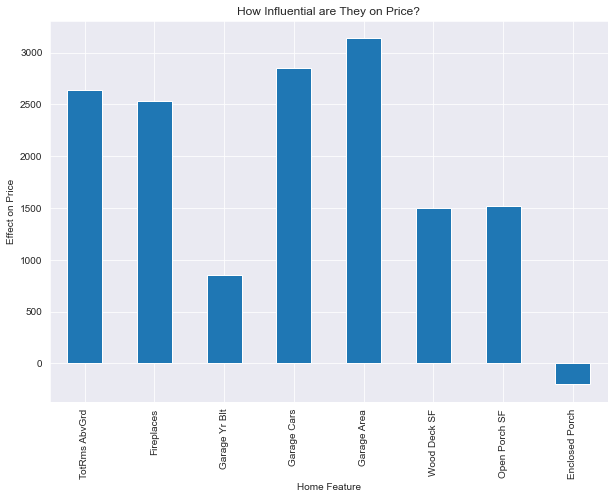

In [437]:
# Visualize strnegth of particular model coefficients:

# Make array of coefficients:
pd.Series(ridge_model.coef_[20:28],index=X.columns[20:28]).plot.bar(figsize=(10, 7))

plt.title('How Influential are They on Price?')
plt.ylabel('Effect on Price')
plt.xlabel('Home Feature');

In [438]:
# Instantiate Lasso
lasso_model = Lasso(alpha=1500)
lasso_model.fit(Xs_train,y_train)

# side by side of Lasso train and test scores
lasso_model.score(Xs_train,y_train), lasso_model.score(Xs_test,y_test)

(0.8995760828817955, 0.7575949840612022)

In [439]:
# Lasso output coefficients: Some have been set to zero from higher value of alpha.
pd.DataFrame(set(zip(X.columns, lasso_model.coef_))).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,Land Contour_Low,Misc Feature_TenC,Roof Matl_Tar&Grv,Exterior 1st_AsphShn,MS Zoning_RM,TotRms AbvGrd,Exterior 2nd_AsphShn,Condition 2_RRAe,Roof Style_Gambrel,Sale Type_Oth,Misc Feature_Shed,Neighborhood_MeadowV,Neighborhood_SawyerW,Alley_Pave,Roof Matl_CompShg,Exterior 1st_WdShing,Exterior 2nd_Brk Cmn,Fireplaces,Exterior 2nd_VinylSd,Neighborhood_Somerst,BsmtFin SF 2,Neighborhood_Gilbert,MS SubClass,Lot Area,Exterior 2nd_Plywood,MS Zoning_RL,Exterior 2nd_MetalSd,Exterior 2nd_Wd Shng,Foundation_Wood,Mas Vnr Type_BrkFace,Wood Deck SF,Condition 1_Norm,Bldg Type_Twnhs,Garage Yr Blt,Kitchen AbvGr,Lot Config_FR3,Exterior 1st_Wd Sdng,Land Contour_Lvl,Pool QC,Neighborhood_StoneBr,Condition 2_Norm,Condition 2_PosA,Heating_GasW,Bsmt Unf SF,Garage Type_Attchd,Exterior 1st_MetalSd,Fence,Garage Area,Neighborhood_NPkVill,Sale Type_WD,Neighborhood_NWAmes,Land Slope,Foundation_Stone,Garage Type_Detchd,Utilities,Garage Type_Basment,Screen Porch,Garage Finish,Condition 1_RRNn,Misc Val,Neighborhood_NAmes,House Style_SLvl,Bsmt Full Bath,Bsmt Half Bath,Lot Config_FR2,Mo Sold,Garage Qual,BsmtFin Type 1,Electrical,Neighborhood_NridgHt,Condition 2_RRAn,Roof Matl_WdShngl,Exter Cond,Neighborhood_Mitchel,Enclosed Porch,Roof Matl_WdShake,Lot Config_Inside,Lot Shape,2nd Flr SF,Heating QC,Exterior 1st_Stone,Sale Type_New,Exterior 1st_CBlock,Mas Vnr Area,Exter Qual,Exterior 2nd_HdBoard,Land Contour_HLS,House Style_2Story,Roof Style_Shed,BsmtFin SF 1,Sale Type_ConLI,Lot Config_CulDSac,Bedroom AbvGr,MS Zoning_C (all),Bldg Type_2fmCon,Neighborhood_Sawyer,Fireplace Qu,MS Zoning_RH,Condition 1_PosA,MS Zoning_FV,House Style_SFoyer,Condition 2_Feedr,Exterior 1st_VinylSd,Half Bath,Garage Type_BuiltIn,Exterior 1st_BrkFace,Open Porch SF,Yr Sold,Misc Feature_Othr,Neighborhood_OldTown,Neighborhood_Landmrk,Garage Type_CarPort,Kitchen Qual,Exterior 2nd_ImStucc,Neighborhood_CollgCr,Street_Pave,Bsmt Qual,Exterior 1st_Plywood,Heating_Grav,Year Built,Bsmt Cond,Sale Type_Con,Neighborhood_Edwards,Exterior 2nd_Stone,Garage Cars,Condition 1_Feedr,Exterior 1st_Stucco,Condition 2_RRNn,Gr Liv Area,Roof Style_Mansard,Condition 2_PosN,House Style_2.5Fin,Total Bsmt SF,Neighborhood_Crawfor,Condition 1_PosN,Condition 1_RRAn,Roof Style_Gable,Roof Matl_Membran,Neighborhood_SWISU,Exterior 2nd_Wd Sdng,Garage Cond,Central Air_Y,Neighborhood_NoRidge,Sale Type_ConLw,3Ssn Porch,Bsmt Exposure,Lot Frontage,Neighborhood_IDOTRR,Foundation_CBlock,Pool Area,Overall Qual,House Style_1Story,Full Bath,Neighborhood_ClearCr,Neighborhood_Timber,Neighborhood_Greens,Mas Vnr Type_None,Exterior 2nd_BrkFace,Neighborhood_GrnHill,Heating_Wall,Functional,Exterior 1st_CemntBd,Neighborhood_Veenker,Neighborhood_BrDale,Bldg Type_Duplex,Roof Style_Hip,Overall Cond,Paved Drive,Exterior 1st_HdBoard,Foundation_PConc,BsmtFin Type 2,Foundation_Slab,Sale Type_CWD,Heating_OthW,1st Flr SF,Low Qual Fin SF,Neighborhood_BrkSide,Exterior 1st_BrkComm,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Bldg Type_TwnhsE,Year Remod/Add,Condition 1_RRNe,House Style_2.5Unf,Exterior 1st_ImStucc,Exterior 2nd_Stucco,MS Zoning_I (all),Neighborhood_Blueste,Condition 1_RRAe,Sale Type_ConLD,Misc Feature_Gar2,Mas Vnr Type_Stone,House Style_1.5Unf
1,0,-0,0,0,-367.066,0,-0,0,-0,0,0,-0,-0,-0,-0,-0,0,2743.08,0,994.92,0,-0,-4790.2,2908.04,-0,0,-0,-0,0,-0,698.407,574.664,-89.7077,-0,-396.172,-0,-0,-0,0,3836.51

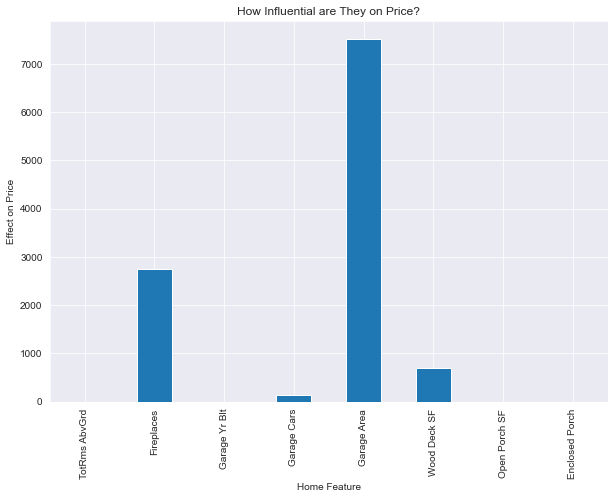

In [440]:
# Visualize strnegth of particular model coefficients:

# Make array of coefficients:
pd.Series(lasso_model.coef_[20:28],index=X.columns[20:28]).plot.bar(figsize=(10, 7))

plt.title('How Influential are They on Price?')
plt.ylabel('Effect on Price')
plt.xlabel('Home Feature');

### Lasso & Ridge Predictions & Metrics:

In [441]:
# Ridge Predictions:
# Same pattern as initial model above:
preds = ridge_model.predict(Xs_test)
resids = y_test - preds

In [442]:
# Calulate RMSE
mean_squared_error(y_test,preds)**.5

42138.5041245021

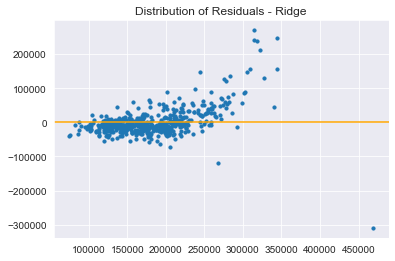

In [443]:
# Display distribution of model residuals.
plt.scatter(preds,resids,s=10)
plt.axhline(0,color='orange')
plt.title('Distribution of Residuals - Ridge',size=12);

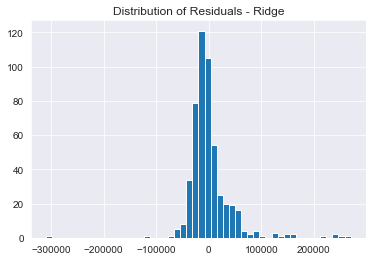

In [444]:
# Validate residual distribution with histogram.
# Ridge Regularization slightly violates regression assumption with distribution of errors.
plt.hist(resids,bins=50)
plt.title('Distribution of Residuals - Ridge',size=12);

In [445]:
# Lasso Predictions & residuals:
# Same pattern as initial model above:
preds = lasso_model.predict(Xs_test)
resids = y_test - preds

In [446]:
# Calulate RMSE
mean_squared_error(y_test,preds)**.5

39389.44252497496

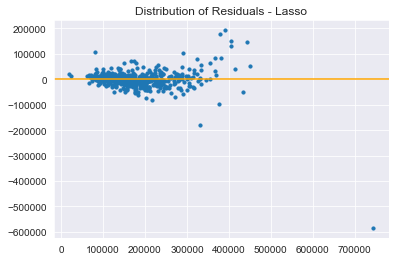

In [447]:
# Display distribution of model residuals.
plt.scatter(preds,resids,s=10)
plt.axhline(0,color='orange')
plt.title('Distribution of Residuals - Lasso',size=12);

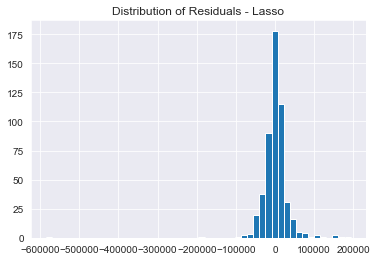

In [448]:
# Validate residual distribution with histogram.

'''Lasso's more unforgiving regularization method has delivered a more robust model with errors
that are essentially normally distributed. There is one large outlier as an exception'''

plt.hist(resids,bins=50)
plt.title('Distribution of Residuals - Lasso',size=12);

### PCA:

In [449]:
# Import PCA 
from sklearn.decomposition import PCA

In [450]:
# 10 Principal Components selected for first analysis:

# Instantiate PCA
pca = PCA(random_state=77,n_components=10)

pca.fit(Xs_train)

# Assign Principal Components to new train and test arrays.
Z_train = pca.transform(Xs_train)
Z_test = pca.transform(Xs_test)

In [451]:
# Fit new regression model for PCA

lr = LinearRegression()
lr.fit(Z_train,y_train)

# Compare scores
# Test score lightly higher than regularized models.
print('Train r2: ',lr.score(Z_train,y_train))
print('Test r2: ',lr.score(Z_test,y_test))

Train r2:  0.8355356400586987
Test r2:  0.7547094950465911


In [452]:
# PCA output coefficients: Some have been set to zero from higher value of alpha.
pd.DataFrame(set(zip(X.columns, lr.coef_))).T

,0,1,2,3,4,5,6,7,8,9
0,Bsmt Unf SF,Lot Area,Lot Frontage,MS SubClass,Mas Vnr Area,Total Bsmt SF,Year Built,BsmtFin SF 1,BsmtFin SF 2,Year Remod/Add
1,350.848,7055.62,3637.73,18060.3,-2772.62,829.281,7756.13,-1278.22,210.918,5952.21


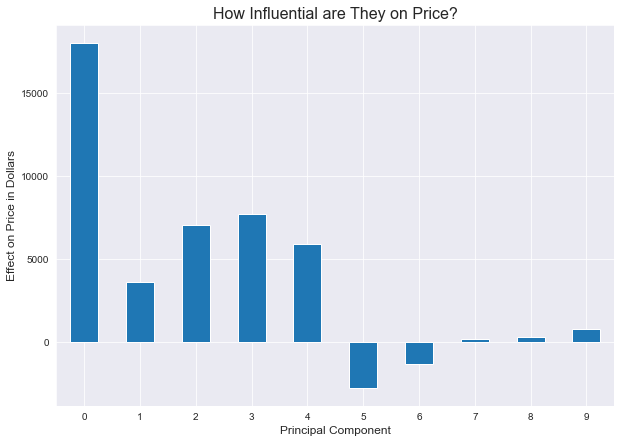

In [453]:
# Visualize strnegth of coefficeients for the 10 Principal Components:

# Place Principal Component Coefficients into array:
pd.Series(lr.coef_,index=pd.DataFrame(Z_train).columns).plot.bar(figsize=(10, 7))

plt.title('How Influential are They on Price?',size=16)
plt.ylabel('Effect on Price in Dollars',size=12)
plt.xticks(size=10,rotation=0)
plt.xlabel('Principal Component',size=12);

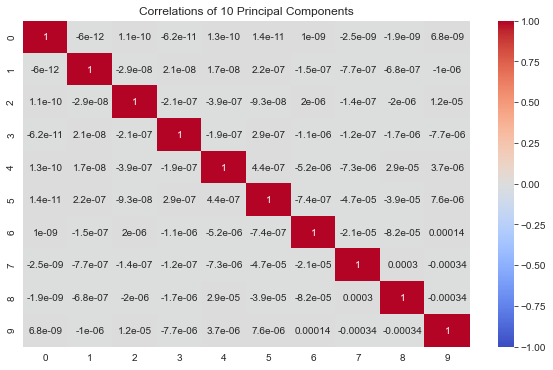

In [454]:
# # Verify that 10 Principal Components are uncorrelated with heatmap.
plt.subplots(figsize=(10,6))
sns.heatmap(pd.DataFrame(Z_train).corr(),annot=True,vmin=-1,vmax=1,cmap='coolwarm')
plt.title('Correlations of 10 Principal Components',size=12);

In [455]:
# PCA Predictions - 10 Components:
preds = lr.predict(Z_test)
resids = y_test - preds

In [456]:
# Calulate RMSE
mean_squared_error(y_test,preds)**.5

39623.18679721299

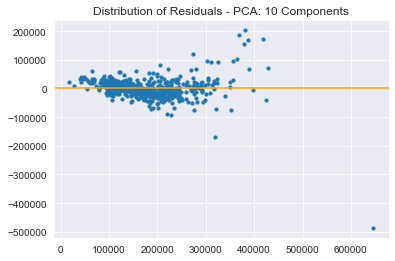

In [457]:
# Display distribution of model residuals.
plt.scatter(preds,resids,s=10)
plt.axhline(0,color='orange')
plt.title('Distribution of Residuals - PCA: 10 Components',size=12);

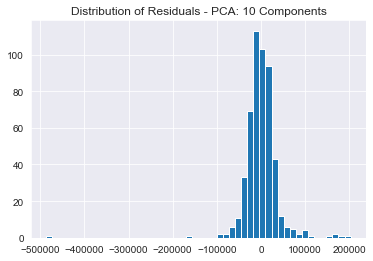

In [458]:
plt.hist(resids,bins=50)
plt.title('Distribution of Residuals - PCA: 10 Components',size=12);

In [459]:
# Evaluate model scores increasing Principal Component amount by 10 up to 100:
# We see different qualities if we compare cross val scores vs. individual scores:

for n in range(10,100,10):

    pca = PCA(random_state=77,n_components=n)

    pca.fit(Xs_train)
    Z_train = pca.transform(Xs_train)
    Z_test = pca.transform(Xs_test)
    
    lr = LinearRegression()
    lr.fit(Z_train,y_train)

    print(f'{n} Principal Components')
    print('------------------------------')
    print('Train r2: ',lr.score(Z_train,y_train))
    print('Test r2: ',lr.score(Z_test,y_test))
    print('CVS train: ',cross_val_score(lr,Z_train,y_train).mean())
    print('CVS test: ',cross_val_score(lr,Z_test,y_test).mean())
    print('RMSE: ',mean_squared_error(y_test,lr.predict(Z_test))**.5)
    print('-------------------------------')

10 Principal Components
------------------------------
Train r2:  0.8355356400586987
Test r2:  0.7547094950465911
CVS train:  0.831093182709729
CVS test:  0.7061342850516488
RMSE:  39623.18679721299
-------------------------------
20 Principal Components
------------------------------
Train r2:  0.8405301504326577
Test r2:  0.7618328083859185
CVS train:  0.8302315570940451
CVS test:  0.6601598008698637
RMSE:  39043.613149094876
-------------------------------
30 Principal Components
------------------------------
Train r2:  0.8473557420552561
Test r2:  0.7747473699698766
CVS train:  0.8288750726916302
CVS test:  0.6529172133239057
RMSE:  37970.29475353895
-------------------------------
40 Principal Components
------------------------------
Train r2:  0.8566460963315597
Test r2:  0.7711142149277597
CVS train:  0.8325604576730488
CVS test:  0.636696026205526
RMSE:  38275.285962447706
-------------------------------
50 Principal Components
------------------------------
Train r2:  0.8629